# Случайный лес с сезонной компонентой

Text(0.5, 1.0, 'AQI')

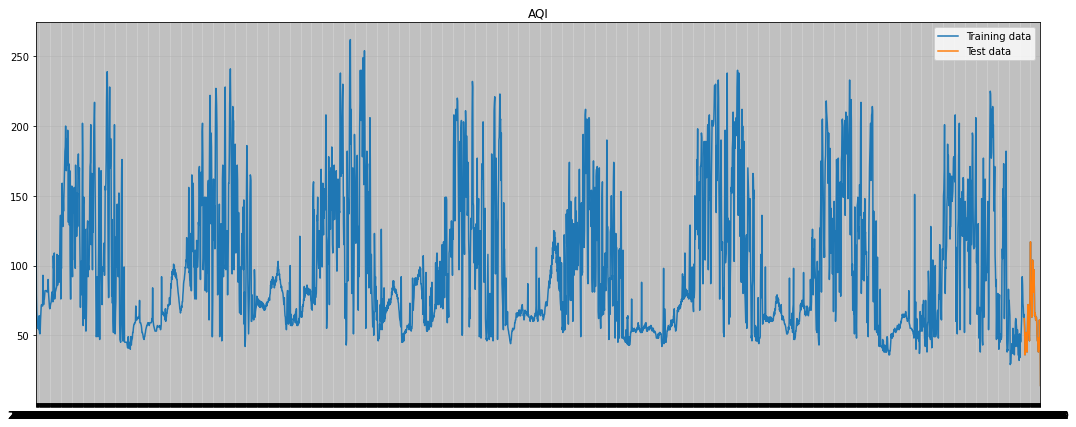

INFO:pycodestyle:10:80: E501 line too long (130 > 79 characters)
INFO:pycodestyle:19:23: E231 missing whitespace after ','


In [11]:
# Импортируем необходмые модули
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from copy import deepcopy

# Скачивание данныъх
data = pd.read_csv("https://raw.githubusercontent.com/dmitry-chvdr/aqi_prediction/Checkpoint4/ts_air_quality_index_2013_2020.csv")
data = data[["aqi", "Date"]]
df = data.set_index('Date').sort_index()

# Разбиваем на трейн тест
df_train = df.iloc[:-48]
df_test = df.iloc[-48:]

# Визуализируем
plt.figure(figsize=(18,7))
plt.plot(df, label="Training data")
plt.plot(df_test, label="Test data")
plt.grid(alpha=0.5)
plt.margins(x=0)
plt.legend()
plt.title("AQI")

# Ниже сам метод и эксперименты

In [18]:
class RandomForestARModel():
    """
Метод для обучения случайного леса на временном ряду
    """

    def __init__(self, n_lags=1, max_depth=3, n_estimators=1000, random_state=123,
                 log_transform=False, first_differences=False, seasonal_differences=None):
        """
        Аргументы:
        n_lags: количество объектов с задержкой, которые необходимо учитывать в авторегрессионной модели.
        max_depth: Максимальная глубина для деревьев регрессии леса
        random_state: случайное состояние для перехода в случайный лес

        log_transform: следует ли преобразовывать входные данные в журнал
        first_differences: должны ли входные данные отличаться по одному
        seasonal_differences: следует учитывать сезонность, если "Нет", то сезонность не предполагается
                """

        self.n_lags = n_lags
        self.model = RandomForestRegressor(max_depth=max_depth, n_estimators=n_estimators, random_state=random_state)

        self.log_transform = log_transform
        self.first_differences = first_differences
        self.seasonal_differences = seasonal_differences

    def fit(self, y):
        """
        Args:
            y: training data (numpy array or pandas series/dataframe)
        """
        # enable pandas functions via dataframes
        y_df = pd.DataFrame(y)
        self.y_df = deepcopy(y_df)

        # apply transformations and store results for retransformations
        if self.log_transform:
            y_df = np.log(y_df)
            self.y_logged = deepcopy(y_df)

        if self.first_differences:
            y_df = y_df.diff().dropna()
            self.y_diffed = deepcopy(y_df)

        if self.seasonal_differences is not None:
            y_df = y_df.diff(self.seasonal_differences).dropna()
            self.y_diffed_seasonal = deepcopy(y_df)

        # get lagged features
        Xtrain = pd.concat([y_df.shift(t) for t in range(1, self.n_lags+1)], axis=1).dropna()
        self.Xtrain = Xtrain

        ytrain = y_df.loc[Xtrain.index, :]
        self.ytrain = ytrain

        self.model.fit(Xtrain.values, ytrain.values.reshape(-1))

    def sample_forecast(self, n_periods=1, n_samples=10000, random_seed=123):
        """
        Составьте прогнозные выборки путем случайного отбора со всех деревьев в лесу за прогнозируемый период
        Аргументы:
        n_periods: количество периодов для прогнозирования
        n_samples: количество образцов для рисования
        random_seed: Случайное начальное значение для numpy
        """
        samples = self._perform_forecast(n_periods, n_samples, random_seed)
        output = self._retransform_forecast(samples, n_periods)

        return output

    def _perform_forecast(self, n_periods, n_samples, random_seed):
        """
        Аргументы:
        n_periods: количество периодов для прогнозирования
        n_samples: количество образцов для рисования
        random_seed: Случайное начальное значение для numpy
        """
        samples = []

        np.random.seed(random_seed)
        for i in range(n_samples):
            # сохраняйте запаздывающей функции для каждого периода
            Xf = np.concatenate([self.Xtrain.iloc[-1, 1:].values.reshape(1, -1),
                                 self.ytrain.iloc[-1].values.reshape(1, 1)], 1)

            forecasts = []

            for t in range(n_periods):
                tree = self.model.estimators_[np.random.randint(len(self.model.estimators_))]
                pred = tree.predict(Xf)[0]
                forecasts.append(pred)

                # update lagged features for next period
                Xf = np.concatenate([Xf[:, 1:], np.array([[pred]])], 1)

            samples.append(forecasts)

        return samples

    def _retransform_forecast(self, samples, n_periods):
        """
        Прогноз повторного преобразования (повторная разница и возведение в степень)
        Аргументы:
        образцы: Прогнозные образцы для преобразования
        n_periods: количество периодов для прогнозирования
        """

        full_sample_tree = []

        for samp in samples:
            draw = np.array(samp)

            # retransform seasonal differencing
            if self.seasonal_differences is not None:
                result = list(self.y_diffed.iloc[-self.seasonal_differences:].values)
                for t in range(n_periods):
                    result.append(result[t]+draw[t])
                result = result[self.seasonal_differences:]
            else:
                result = []
                for t in range(n_periods):
                    result.append(draw[t])

            # retransform first differences
            y_for_add = self.y_logged.values[-1] if self.log_transform else self.y_df.values[-1]

            if self.first_differences:
                result = y_for_add + np.cumsum(result)

            # retransform log transformation
            if self.log_transform:
                result = np.exp(result)

            full_sample_tree.append(result.reshape(-1, 1))

        return np.concatenate(full_sample_tree, 1)

INFO:pycodestyle:6:80: E501 line too long (82 > 79 characters)
INFO:pycodestyle:7:80: E501 line too long (90 > 79 characters)
INFO:pycodestyle:10:80: E501 line too long (105 > 79 characters)
INFO:pycodestyle:16:80: E501 line too long (103 > 79 characters)
INFO:pycodestyle:20:80: E501 line too long (117 > 79 characters)
INFO:pycodestyle:49:80: E501 line too long (93 > 79 characters)
INFO:pycodestyle:59:80: E501 line too long (109 > 79 characters)
INFO:pycodestyle:82:80: E501 line too long (80 > 79 characters)
INFO:pycodestyle:88:80: E501 line too long (93 > 79 characters)
INFO:pycodestyle:101:80: E501 line too long (84 > 79 characters)
INFO:pycodestyle:114:80: E501 line too long (85 > 79 characters)
INFO:pycodestyle:124:80: E501 line too long (96 > 79 characters)


# Обучение RandomForest<br>
## Выполним серию экспериментов <br>
## Работаем с:<br>
*-n_lags*<br>
*-сезонной компонентой (sc)*<br> 

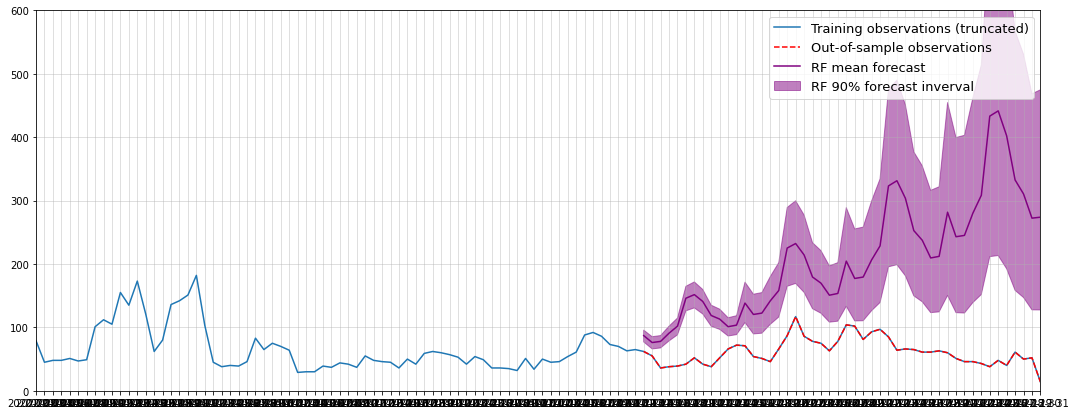

INFO:pycodestyle:2:80: E501 line too long (106 > 79 characters)
INFO:pycodestyle:6:80: E501 line too long (83 > 79 characters)
INFO:pycodestyle:21:80: E501 line too long (122 > 79 characters)


In [20]:
# Обучим Random Forest (n_lags = 2; sc = 12)
model = RandomForestARModel(n_lags=2, log_transform=True, first_differences=True, seasonal_differences=12)
model.fit(df_train)

# Выполним предсказание
predictions_forest = model.sample_forecast(n_periods=len(df_test), n_samples=10000)

# Найдем квантиль для доверительного интервала
means_forest = np.mean(predictions_forest, 1)
lowers_forest = np.quantile(predictions_forest, 0.05, 1)
uppers_forest = np.quantile(predictions_forest, 0.95, 1)

# Визуализируем
plt.figure(figsize=(18, 7))
plt.ylim([0, 600])
plt.grid(alpha=0.5)

plt.plot(df.iloc[-120:], label="Training observations (Air Quality Index)")
plt.plot(df_test, color="red", label="Out-of-sample observations", ls="dashed")
plt.plot(df_test.index, means_forest, color="purple", label="RF mean forecast")
plt.fill_between(df_test.index, lowers_forest, uppers_forest, color="purple", alpha=0.5, label="RF 90% forecast inverval")

plt.legend(fontsize=13)
plt.margins(x=0)

In [21]:
# Найдем ошибку
error = mean_absolute_error(df_test, means_forest)
error

146.80251827630377

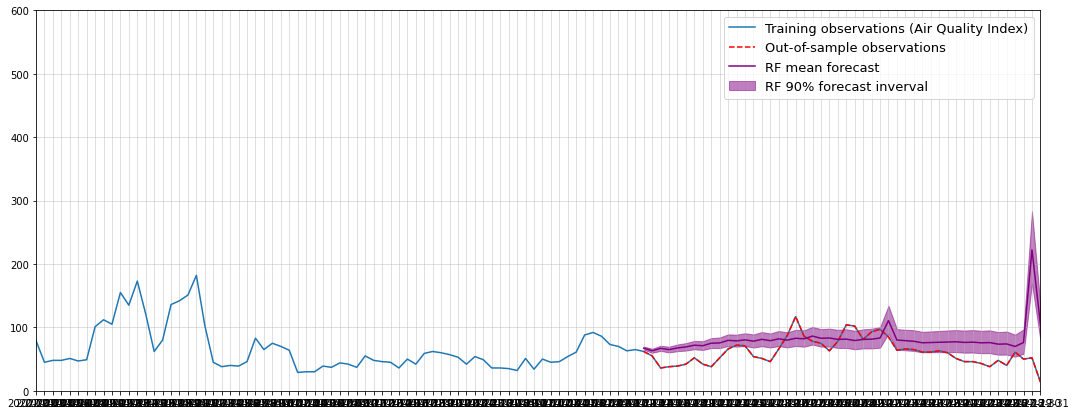

INFO:pycodestyle:2:80: E501 line too long (107 > 79 characters)
INFO:pycodestyle:6:80: E501 line too long (83 > 79 characters)
INFO:pycodestyle:22:80: E501 line too long (122 > 79 characters)


In [23]:
# Обучим Random Forest (n_lags = 1; sc = 365)
model = RandomForestARModel(n_lags=1, log_transform=True, first_differences=True, seasonal_differences=365)
model.fit(df_train)

# Выполним предсказание
predictions_forest = model.sample_forecast(n_periods=len(df_test), n_samples=10000)

# Найдем квантиль для доверительного интервала
means_forest = np.mean(predictions_forest, 1)
lowers_forest = np.quantile(predictions_forest, 0.05, 1)
uppers_forest = np.quantile(predictions_forest, 0.95, 1)

# Визуализируем
plt.figure(figsize=(18, 7))
plt.ylim([0, 600])
plt.grid(alpha=0.5)

plt.plot(df.iloc[-120:], label="Training observations (Air Quality Index)")
plt.plot(df_test, color="red", label="Out-of-sample observations", ls="dashed")
plt.plot(df_test.index, means_forest, color="purple", label="RF mean forecast")

plt.fill_between(df_test.index, lowers_forest, uppers_forest, color="purple", alpha=0.5, label="RF 90% forecast inverval")

plt.legend(fontsize=13)
plt.margins(x=0)

In [25]:
# Найдем ошибку
error = mean_absolute_error(df_test, means_forest)
error

24.308364399193213

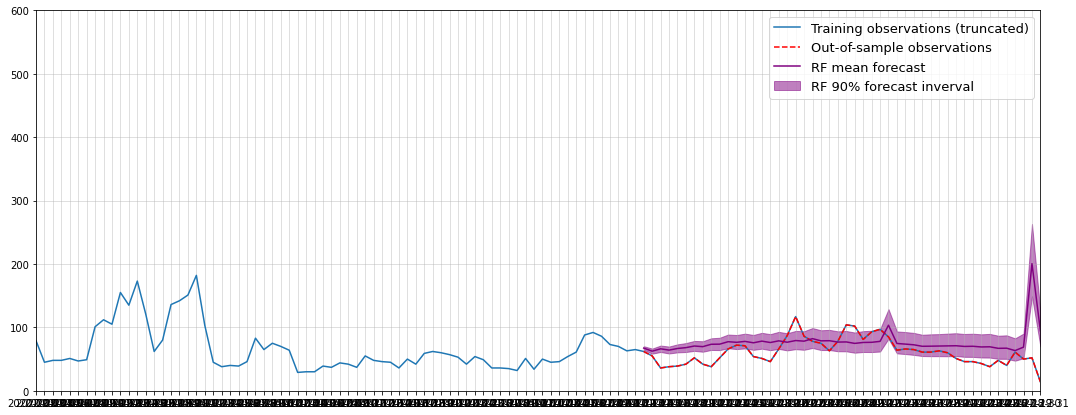

INFO:pycodestyle:2:80: E501 line too long (107 > 79 characters)
INFO:pycodestyle:6:80: E501 line too long (83 > 79 characters)
INFO:pycodestyle:22:80: E501 line too long (122 > 79 characters)


In [27]:
# Обучим Random Forest (n_lags = 2; sc = 365)
model = RandomForestARModel(n_lags=2, log_transform=True, first_differences=True, seasonal_differences=365)
model.fit(df_train)

# Выполним предсказаниt
predictions_forest = model.sample_forecast(n_periods=len(df_test), n_samples=10000)

# Найдем квантиль для доверительного интервала
means_forest = np.mean(predictions_forest, 1)
lowers_forest = np.quantile(predictions_forest, 0.05, 1)
uppers_forest = np.quantile(predictions_forest, 0.95, 1)

# Визуализируем
plt.figure(figsize=(18, 7))
plt.ylim([0, 600])
plt.grid(alpha=0.5)

plt.plot(df.iloc[-120:], label="Training observations (truncated)")
plt.plot(df_test, color="red", label="Out-of-sample observations", ls="dashed")
plt.plot(df_test.index, means_forest, color="purple", label="RF mean forecast")

plt.fill_between(df_test.index, lowers_forest, uppers_forest, color="purple", alpha=0.5, label="RF 90% forecast inverval")

plt.legend(fontsize=13)
plt.margins(x=0)

In [28]:
# Найдем ошибку
error = mean_absolute_error(df_test, means_forest)
error

21.244567870744493

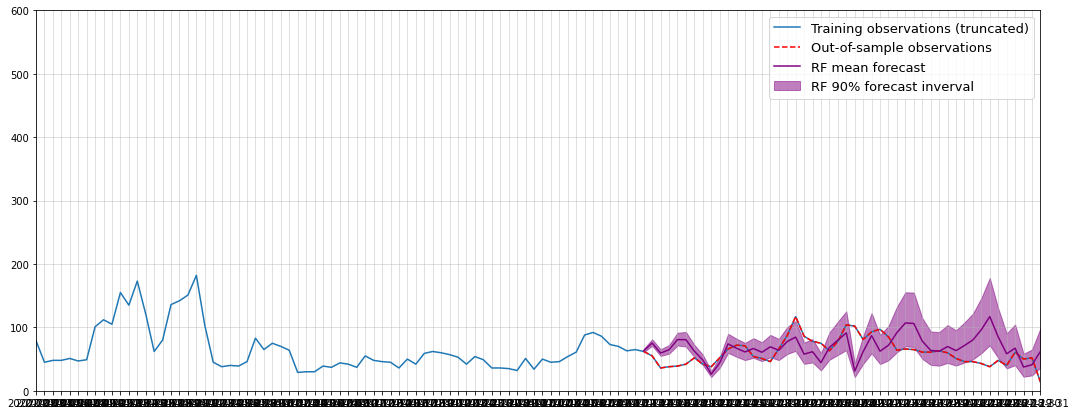

INFO:pycodestyle:2:80: E501 line too long (107 > 79 characters)
INFO:pycodestyle:6:80: E501 line too long (83 > 79 characters)
INFO:pycodestyle:22:80: E501 line too long (122 > 79 characters)


In [30]:
# Обучим Random Forest (n_lags = 1; sc = 182)
model = RandomForestARModel(n_lags=1, log_transform=True, first_differences=True, seasonal_differences=182)
model.fit(df_train)

# Выполним предсказание
predictions_forest = model.sample_forecast(n_periods=len(df_test), n_samples=10000)

# Найдем квантиль для доверительного интервала
means_forest = np.mean(predictions_forest, 1)
lowers_forest = np.quantile(predictions_forest, 0.05, 1)
uppers_forest = np.quantile(predictions_forest, 0.95, 1)

# Визуализируем
plt.figure(figsize=(18, 7))
plt.ylim([0, 600])
plt.grid(alpha=0.5)

plt.plot(df.iloc[-120:], label="Training observations (truncated)")
plt.plot(df_test, color="red", label="Out-of-sample observations", ls="dashed")
plt.plot(df_test.index, means_forest, color="purple", label="RF mean forecast")

plt.fill_between(df_test.index, lowers_forest, uppers_forest, color="purple", alpha=0.5, label="RF 90% forecast inverval")

plt.legend(fontsize=13)
plt.margins(x=0)

In [31]:
# Найдем ошибку
error = mean_absolute_error(df_test, means_forest)
error

21.203977587452894

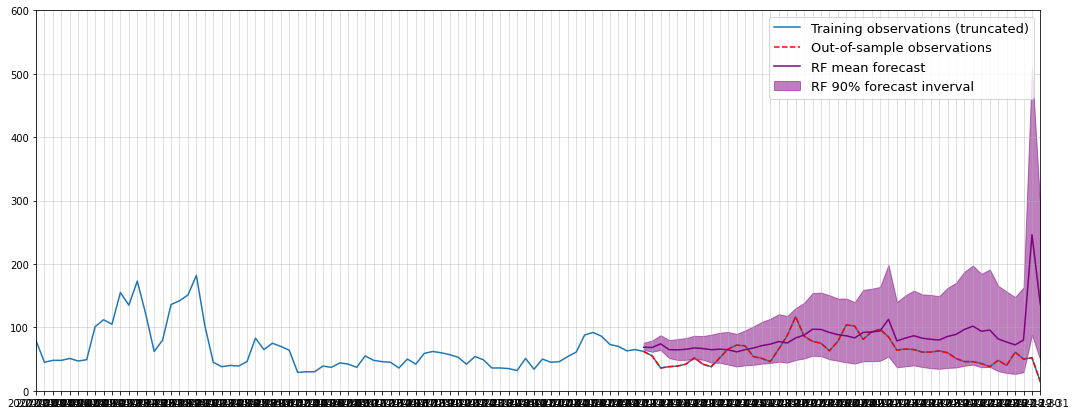

INFO:pycodestyle:2:80: E501 line too long (108 > 79 characters)
INFO:pycodestyle:6:80: E501 line too long (83 > 79 characters)
INFO:pycodestyle:22:80: E501 line too long (122 > 79 characters)


In [32]:
# Обучим Random Forest (n_lags = 60; sc = 365)
model = RandomForestARModel(n_lags=60, log_transform=True, first_differences=True, seasonal_differences=365)
model.fit(df_train)

# Выполним предсказание
predictions_forest = model.sample_forecast(n_periods=len(df_test), n_samples=10000)

# Найдем квантиль для доверительного интервала
means_forest = np.mean(predictions_forest, 1)
lowers_forest = np.quantile(predictions_forest, 0.05, 1)
uppers_forest = np.quantile(predictions_forest, 0.95, 1)

# Визуализируем
plt.figure(figsize=(18, 7))
plt.ylim([0, 600])
plt.grid(alpha=0.5)

plt.plot(df.iloc[-120:], label="Training observations (truncated)")
plt.plot(df_test, color="red", label="Out-of-sample observations", ls="dashed")
plt.plot(df_test.index, means_forest, color="purple", label="RF mean forecast")

plt.fill_between(df_test.index, lowers_forest, uppers_forest, color="purple", alpha=0.5, label="RF 90% forecast inverval")

plt.legend(fontsize=13)
plt.margins(x=0)

In [33]:
# Найдем ошибку
error = mean_absolute_error(df_test, means_forest)
error

27.709415751464462

# Наилучший результат: <br>
*Random Forest (n_lags = 1; sc = 182)*<br>
*МАЕ = 21.2*
